## Stationary data analysis - Simulated Data

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pept import LineData, Pipeline, PointData
from pept.tracking import Stack, HDBSCAN, Cutpoints, SplitLabels, Centroids
# from scipy.interpolate import interp1d
from skopt import gp_minimize
from skopt.space import Real, Integer
import sys
sys.path.append("/home/rayhaan/REPO_HR++/GATE_HR/GeneralScripts/")
from interpolateTime import interpolateUnique
from tqdm import tqdm
matplotlib.use("pgf")
matplotlib.rcParams.update({ # Makes the plots look nice
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib widget

Below function is to read in the raw LORs.  

In [23]:
# def loadTruePath(path: str) -> PointData:
#     data = np.loadtxt(path, skiprows = 3)
#     points = np.array([data[:, 0], data[:, 5], data[:, 6], data[:, 7]]).T
#     pData = PointData(points)
#     return pData

def loadData(path: str) -> LineData:
    lines = np.load(path)
    rawLines = np.array([lines[:, 6], lines[:, 0], lines[:, 1], lines[:, 2], lines[:, 3], lines[:, 4], lines[:, 5]]).T
    lData = LineData(rawLines)
    return lData

In [24]:
pathToLors = "/home/rayhaan/REPO_HR++/GATE_HR/NPYOutput/testStationary_XYZ_20_20_20_mm_1mCi_1s_NRW-100_68Ga.npy"
lors = loadData(path = pathToLors)

# Interpolation algorithm.  Paper that we worked on.  Improves spatiotemporal resolution.  
times = lors['t']
newTime = interpolateUnique(msTime = times)
lors_2 = LineData(np.c_[newTime, lors.lines[:, 1:7]])

This is now what the LORs look like.  

In [25]:
print(lors_2)

pept.LineData (samples: 1)
--------------------------
sample_size = 305965
overlap = 0
lines = 
  (rows: 305965, columns: 7)
  [[ 0.00000000e+00 -3.92910065e+02 ...  1.88426865e+02 -7.44099998e+00]
   [ 3.28947368e-06 -3.82466797e+02 ...  4.12149902e+02 -2.59100008e+00]
   ...
   [ 1.99563300e+00 -2.04615387e+02 ... -7.37368536e+00  1.09955002e+02]
   [ 1.99900000e+00  3.61434143e+02 ... -2.21409485e+02  7.56729965e+01]]
columns = ['t', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2']
attrs = {}



Now lets perform some optimsiation since we know the location.  We want to optimise the tracking parameters.  

We know the true location!

In [26]:
trueLocation = np.array([20, 20, 20]).astype(np.float32) # X, Y, Z

The first function is the error fucntion which will be minimised and the second function actually performs the minimisation of uncertainty by trying to find the optimal tracking parameters for PEPT-ML

In [27]:
def errorCalculation(locs: PointData, trueLocation: np.ndarray) -> float:
    lenght = len(locs['x'])
    uX = np.sum(np.abs(locs['x'] - trueLocation[0]))/lenght
    uY = np.sum(np.abs(locs['y'] - trueLocation[0]))/lenght
    uZ = np.sum(np.abs(locs['z'] - trueLocation[0]))/lenght

    combinedUncertainty = np.sqrt(uX**2 + uY**2 + uZ**2)

    return combinedUncertainty


def optAllML(lowerLocRate, upperLocRate, Data, trueLocation, totalTime):

    # out = []

# for i in tqdm(range(len(UsedSampleSizes)-1)):
    def ObjectiveML(x):
        MLPipe = Pipeline([
            Stack(sample_size = x[0], overlap = 0),
            Cutpoints(max_distance = 1.0),
            HDBSCAN(true_fraction = x[1]),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = x[2]),
            SplitLabels() + Centroids(),
            Stack()
        ])

        locs = MLPipe.fit(Data, verbose = True, max_workers = 100)

        locRate = len(locs.points)/totalTime

        error = errorCalculation(locs = locs, trueLocation = trueLocation)

        if (locRate >= lowerLocRate) and (locRate <= upperLocRate):
            error = error
        else:
            error = 10000 + error

        print("The error is: {} mm, the location rate is: {} kHz".format(error, locRate))

        return error

    # The optimisation space!
    space = [Integer(250, 300, name = 'SS1'),
            # Real(1.0, 3.0, name = 'MD'),
            Real(0.1, 0.6, name = 'TF1'),
            Real(0.55, 0.65, name = 'TF2'),
                    ]

    res = gp_minimize(ObjectiveML, space, n_calls = 10, verbose = True, random_state = 254654)

    out1 = [res.fun, res.x[0], res.x[1], res.x[2]]

    return out1

In [28]:
optimalParameters = optAllML(lowerLocRate = 900, upperLocRate = 1100, Data = lors_2, trueLocation = trueLocation, totalTime = 1.0)

Iteration No: 1 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1078/1078 [00:01<00:00, 1005.53it/s]



Processed samples in 8.428376197814941 s

The error is: 10000.21366108505 mm, the location rate is: 217.0 kHz
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.4314
Function value obtained: 10000.2137
Current minimum: 10000.2137
Iteration No: 2 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1148/1148 [00:01<00:00, 1062.15it/s]



Processed samples in 3.7588233947753906 s

The error is: 0.16948185000261046 mm, the location rate is: 1090.0 kHz
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.7631
Function value obtained: 0.1695
Current minimum: 0.1695
Iteration No: 3 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1133/1133 [00:01<00:00, 1068.00it/s]



Processed samples in 7.3541975021362305 s

The error is: 0.16210937412652915 mm, the location rate is: 1058.0 kHz
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.3581
Function value obtained: 0.1621
Current minimum: 0.1621
Iteration No: 4 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [00:02<00:00, 503.27it/s]



Processed samples in 9.253853797912598 s

The error is: 10000.222372577964 mm, the location rate is: 165.0 kHz
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 9.2578
Function value obtained: 10000.2224
Current minimum: 0.1621
Iteration No: 5 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1165/1165 [00:01<00:00, 1093.24it/s]



Processed samples in 5.77770209312439 s

The error is: 10000.194589193703 mm, the location rate is: 155.0 kHz
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 5.7813
Function value obtained: 10000.1946
Current minimum: 0.1621
Iteration No: 6 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1124/1124 [00:01<00:00, 777.72it/s]



Processed samples in 5.145186901092529 s

The error is: 0.1600615242761934 mm, the location rate is: 1054.0 kHz
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 5.1492
Function value obtained: 0.1601
Current minimum: 0.1601
Iteration No: 7 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1171/1171 [00:01<00:00, 1045.33it/s]



Processed samples in 4.229269742965698 s

The error is: 0.16522435505263303 mm, the location rate is: 1096.0 kHz
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 4.2330
Function value obtained: 0.1652
Current minimum: 0.1601
Iteration No: 8 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1065/1065 [00:01<00:00, 1006.46it/s]



Processed samples in 5.392204523086548 s

The error is: 0.15611885625860084 mm, the location rate is: 985.0 kHz
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 5.3978
Function value obtained: 0.1561
Current minimum: 0.1561
Iteration No: 9 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1002/1002 [00:01<00:00, 955.18it/s]



Processed samples in 5.968279600143433 s

The error is: 10000.19621260789 mm, the location rate is: 160.0 kHz
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 5.9739
Function value obtained: 10000.1962
Current minimum: 0.1561
Iteration No: 10 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1043/1043 [00:01<00:00, 1001.74it/s]



Processed samples in 7.2448155879974365 s

The error is: 10000.206018833276 mm, the location rate is: 139.0 kHz
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 7.7319
Function value obtained: 10000.2060
Current minimum: 0.1561


Great!  The tracking parameters are now optimised enough.  Enough in that we have the location rate we're looking for (+- 1.0 kHz) and the tracking parrameters that minimise the error around that location rate.  This was performed with the use of Gaussian processes since a grid based approach would take forever.  

In [30]:
print("The optimal Tracking Parameters are:")
Params = ["SS1", "TF1", "TF1"]
for i in range(len(Params)):
    print("{} = {}".format(Params[i], optimalParameters[i]))

The optimal Tracking Parameters are:
SS1 = 0.15611885625860084
TF1 = 277
TF1 = 0.3379744086916586


Now lets track using these optimal parameters!

In [32]:
MLPipeOpt = Pipeline([
            Stack(sample_size = optimalParameters[1], overlap = 0),
            Cutpoints(max_distance = 3.0),
            HDBSCAN(true_fraction = optimalParameters[2]),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = optimalParameters[3]),
            SplitLabels() + Centroids(),
            Stack()
        ])

In [33]:
locations = MLPipeOpt.fit(lors_2, max_workers = 100, verbose = True)

Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1063/1063 [00:00<00:00, 1077.78it/s]



Processed samples in 21.265925884246826 s



Awesome!  Now we have our locations.  At this point we can do whatever we want with the locations now.  let's visualise the locations

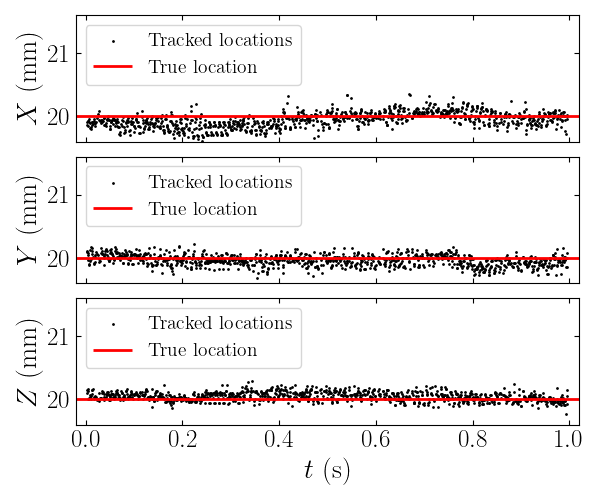

In [59]:
plt.close("all")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (6, 5), sharex = "col", sharey = "col")

s = 20

ax1.scatter(locations['t'], locations['x'], s = 1, color = 'k', label = "Tracked locations")
ax2.scatter(locations['t'], locations['y'], s = 1, color = 'k', label = "Tracked locations")
ax3.scatter(locations['t'], locations['z'], s = 1, color = 'k', label = "Tracked locations")

ax1.hlines(y = 20.0, xmin = -0.5, xmax = 1.5, color = 'r', lw = 2, label = "True location")
ax2.hlines(y = 20.0, xmin = -0.5, xmax = 1.5, color = 'r', lw = 2, label = "True location")
ax3.hlines(y = 20.0, xmin = -0.5, xmax = 1.5, color = 'r', lw = 2, label = "True location")

ax1.legend(loc = "upper left", fontsize = s - 6)
ax2.legend(loc = "upper left", fontsize = s - 6)
ax3.legend(loc = "upper left", fontsize = s - 6)


ax1.get_xaxis().set_tick_params(direction = "in", which = "both", top = True)
ax1.get_yaxis().set_tick_params(direction = "in", which = "both", right = True)
ax2.get_xaxis().set_tick_params(direction = "in", which = "both", top = True)
ax2.get_yaxis().set_tick_params(direction = "in", which = "both", right = True)
ax3.get_xaxis().set_tick_params(direction = "in", which = "both", top = True)
ax3.get_yaxis().set_tick_params(direction = "in", which = "both", right = True)

ax1.tick_params(axis="x", labelsize = s - 2) 
ax1.tick_params(axis="y", labelsize = s - 2)
ax2.tick_params(axis="x", labelsize = s - 2) 
ax2.tick_params(axis="y", labelsize = s - 2)
ax3.tick_params(axis="x", labelsize = s - 2) 
ax3.tick_params(axis="y", labelsize = s - 2)

ax1.set_xlim(-0.02, 1.02)
ax1.set_ylim(19.6, 21.6)

ax3.set_xlabel(r"$t$ (s)", fontsize = s)

ax1.set_ylabel(r"$X$ (mm)", fontsize = s)
ax2.set_ylabel(r"$Y$ (mm)", fontsize = s)
ax3.set_ylabel(r"$Z$ (mm)", fontsize = s)

fig.tight_layout()
# fig.savefig("/home/rayhaan/REPO_HR++/GATE_HR/Notebooks/StationaryTest.png", dpi = 300)


You can now do whatever you want.  You could quantify the spread in the stationary location by histogramming the locations and fitting a Gaussian to the histogram data.  